### Import

NOTE: Tensorflow is only supporting to x64

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Import CSV

In [2]:
df = pd.read_csv('tesla.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-05-03,703.799988,706.000000,680.500000,684.900024,684.900024,27043100
1,2021-05-04,678.940002,683.450012,657.700012,673.599976,673.599976,29739300
2,2021-05-05,681.059998,685.299988,667.340027,670.940002,670.940002,21901900
3,2021-05-06,680.760010,681.020020,650.000000,663.539978,663.539978,27784600
4,2021-05-07,665.799988,690.000000,660.219971,672.369995,672.369995,23469200


### Data Selection and Display

In [4]:
df = df[['Date', 'Close']]

In [5]:
df.Date = pd.to_datetime(df.Date, format = '%Y/%m/%d')
plot = df.set_index('Date')

<AxesSubplot:xlabel='Date'>

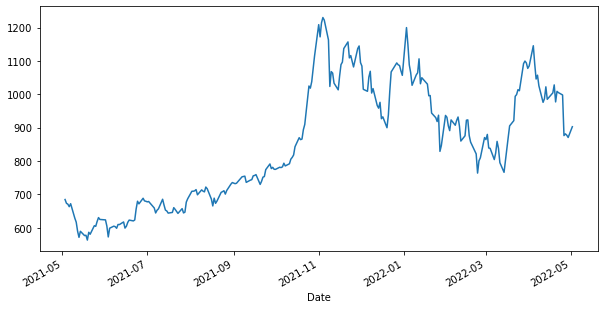

In [6]:
plot['Close'].plot(figsize=(10,5))

### Data Preparation

In [7]:
df = df.drop('Date', axis = 1)
df = df.reset_index(drop = True)
df.head()
T = df.values
T = T.astype('float32')
T = np.reshape(T, (-1, 1))

#### Scale Data

In [8]:
scaler = MinMaxScaler(feature_range = (0, 1))
T = scaler.fit_transform(T)

train_size = int(len(T) * 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]

#### Feature Function

In [9]:
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

window_size = 20
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#### Check for Train/Test Data Leaks

In [10]:
T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T_shape, train_shape, test_shape))

False


### Build LSTM Model

In [11]:
tf.random.set_seed(11)
np.random.seed(11)

In [12]:
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', #return_sequences = True, 
               input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [13]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

model.summary()

Epoch 1/100
10/10 [==============================] - 1s 18ms/step - loss: 0.2801 - val_loss: 0.4098
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 0.1724 - val_loss: 0.2549
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0968 - val_loss: 0.1396
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0443 - val_loss: 0.0691
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0235 - val_loss: 0.0406
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0352
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.0346
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0175 - val_loss: 0.0359
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.0353
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0329
Epoch 11

Epoch 83/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 84/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 85/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0085
Epoch 86/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 87/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 88/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0083
Epoch 89/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0091
Epoch 90/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 91/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 92/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0082


In [14]:
def plot_loss(train_loss, val_loss, Title):
    x = [i for i in range(0, len(val_loss))]
    y= train_loss
    plt.plot(x,y)

    x = [i for i in range(0, len(val_loss))]
    y= val_loss
    plt.plot(x,y)
    
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=0.31)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    #plt.xlim(xmax=50)
    plt.grid(True)
    ax = plt.gca()
    ax.set_xticks(ax.get_xticks()[::4])
    plt.title(Title)
    plt.show()

In [15]:
history_dict = history.history
print(history_dict.keys())
print(max(history.history['loss']))

dict_keys(['loss', 'val_loss'])
0.2800547480583191


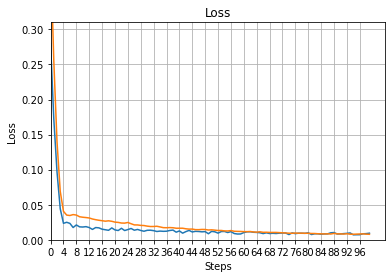

In [16]:
plot_loss(history.history['loss'],history.history['val_loss'], "Loss")

In [17]:
train_predict = model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

print(Y_hat_train.shape)
print(Y_hat_test.shape)

(181, 1)
(30, 1)


In [18]:
Y_hat_train = np.reshape(Y_hat_train, newshape = 181)
Y_hat_test = np.reshape(Y_hat_test, newshape = 30)

Y_train = np.reshape(Y_train, newshape = 181)
Y_test = np.reshape(Y_test, newshape = 30)

### Performance

In [19]:
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
44.63508023481787 

Test RMSE is: 
59.06264555663863


### Output

In [20]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

In [21]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat

result_df.head()

,Actual_Y,Predicted_Y
0,623.900030,633.734314
1,605.119983,639.614075
2,572.840019,630.473999
3,599.049992,624.919006
4,605.129993,620.726685


Text(0, 0.5, 'Value of Tesla Stock')

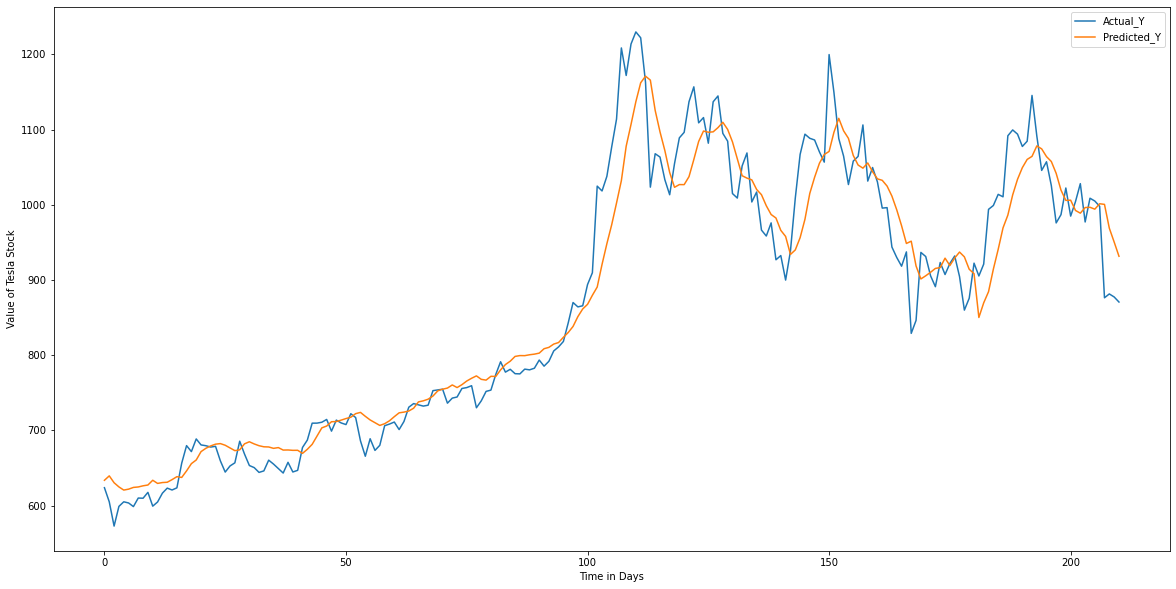

In [22]:
result_df.plot(figsize=(20,10))
plt.xlabel('Time in Days')
plt.ylabel('Value of Tesla Stock')